# **Configuração do Ambiente**

**Rode somente a célula abaixo; em seguida reinicie o ambiente de execução, e roda as demais.**

In [1]:
'''
!pip uninstall -y fastai thinc
!pip install numpy==1.26.4 --quiet
!pip install timm
'''

'\n!pip uninstall -y fastai thinc\n!pip install numpy==1.26.4 --quiet\n!pip install timm\n'

# **Imports**

In [1]:
import os
import re
import json
import random
import pandas as pd
from collections import Counter
import torch
from torch.utils.data import Dataset
import kagglehub
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, AutoTokenizer
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from transformers import EarlyStoppingCallback
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import timm
import torch.nn as nn
import seaborn as sns
from tqdm import tqdm

C:\Users\pamga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **Pré-processamento**

## **Carregar o Dataset**

**Primeiro, é realizado o carregamento dos dados e a inicialização das variáveis.**

In [5]:
path = kagglehub.dataset_download("victorcallejasf/multimodal-hate-speech")

print("Path to dataset files:", path)

print(os.listdir(path))

json_gt_path = os.path.join(path, "MMHS150K_GT.json")
splits_paths = {
    "Treino": os.path.join(path, "splits", "train_ids.txt"),
    "Validação": os.path.join(path, "splits", "val_ids.txt"),
    "Teste": os.path.join(path, "splits", "test_ids.txt"),
}

with open(json_gt_path, 'r') as f:
    full_data_json = json.load(f)

Path to dataset files: C:\Users\pamga\.cache\kagglehub\datasets\victorcallejasf\multimodal-hate-speech\versions\1
['hatespeech_keywords.txt', 'img_resized', 'img_txt', 'MMHS150K_GT.json', 'MMHS150K_readme.txt', 'splits']


## **Analise da distribuição de classes**

Realizamos uma analise inicial da distribuição das classes no dataset. Existem 6 labels no dataset:

* 0: "Não é hate"
* 1: "Racista"
* 2: "Sexista"
* 3: "Homofóbico"
* 4: "Religião"
* 5: "Outro"

Na análise, observamos que a label "Não Hate" possui uma quantidade significativamente maior de ocorrências. As demais categorias, que representam diferentes tipos de discurso de ódio, estão distribuídas entre os tipos, mas de forma desproporcional. Além disso, quando comparadas ao volume de "Não Hate", essas categorias representam uma parcela muito menor do total.

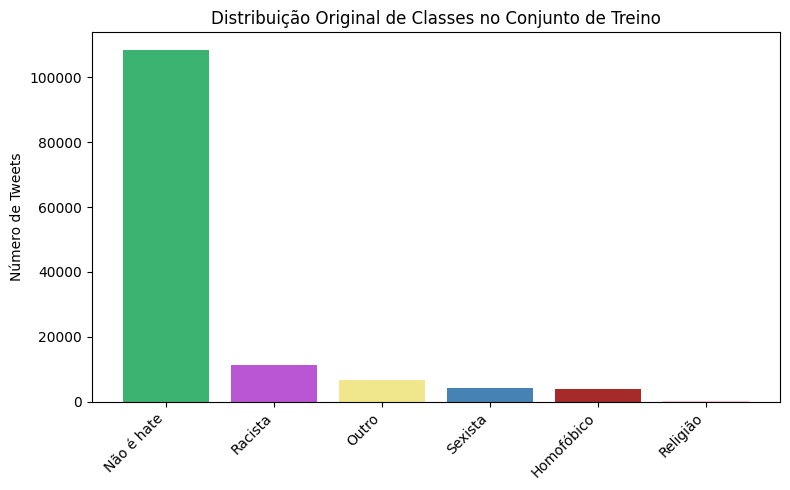

In [6]:
with open(splits_paths['Treino'], 'r') as f:
    train_ids = [line.strip() for line in f.readlines()]

original_train_labels = []
for tweet_id in train_ids:
    if tweet_id in full_data_json:
        label_list = full_data_json[tweet_id]['labels']
        most_common = Counter(label_list).most_common(1)[0][0]
        original_train_labels.append(most_common)

labels_map_multiclass = {
    0: "Não é hate", 1: "Racista", 2: "Sexista",
    3: "Homofóbico", 4: "Religião", 5: "Outro"
}

original_label_counts = Counter(original_train_labels)
df_dist_multi = pd.DataFrame({
    'Classe': [labels_map_multiclass[label] for label, count in original_label_counts.items()],
    'Quantidade': [count for label, count in original_label_counts.items()]
}).sort_values(by='Quantidade', ascending=False)

# Plotando o gráfico
plt.figure(figsize=(8, 5))
plt.bar(df_dist_multi['Classe'], df_dist_multi['Quantidade'], color=['mediumseagreen', 'mediumorchid', 'khaki', 'steelblue', 'brown', 'pink'])
plt.title('Distribuição Original de Classes no Conjunto de Treino')
plt.ylabel('Número de Tweets')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## **Transformação do Dados**

Foi realizada uma limpeza nos dados, removendo URLs, menções (@) e hashtags (#) dos textos. Em seguida, os textos limpos passaram pelo processo de tokenização, a fim de prepará-los no formato compatível com o modelo BERTweet.

In [7]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

def process_and_binarize_example(example):
    example['text'] = clean_text(example['text'])
    majority_vote = Counter(example['labels_multi']).most_common(1)[0][0]
    example['label'] = 0 if majority_vote == 0 else 1

    return example

model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=False)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

all_data_list = [{'tweet_id': k, 'text': v['tweet_text'], 'labels_multi': v['labels']} for k, v in full_data_json.items()]
full_dataset = Dataset.from_list(all_data_list)

split_ids_set = {k.lower(): set(open(v, 'r').read().splitlines()) for k, v in splits_paths.items()}
raw_datasets = DatasetDict({
    'train': full_dataset.filter(lambda x: x['tweet_id'] in split_ids_set['treino']),
    'validation': full_dataset.filter(lambda x: x['tweet_id'] in split_ids_set['validação']),
    'test': full_dataset.filter(lambda x: x['tweet_id'] in split_ids_set['teste'])
})

#processed_datasets = raw_datasets.map(process_and_binarize_example, remove_columns=['labels_multi', 'tweet_id'])
processed_datasets = raw_datasets.map(process_and_binarize_example, remove_columns=['labels_multi'])

tokenized_datasets = processed_datasets.map(tokenize_function, batched=True, remove_columns=['text'])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

# Salvar em treino, validação e teste
train_dataset = tokenized_datasets["train"]
val_dataset = tokenized_datasets["validation"]
test_dataset = tokenized_datasets["test"]

print(tokenized_datasets)

Map: 100%|██████████| 10000/10000 [00:04<00:00, 2176.11 examples/s]

DatasetDict({
    train: Dataset({
        features: ['tweet_id', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 134823
    })
    validation: Dataset({
        features: ['tweet_id', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['tweet_id', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10000
    })
})


## **Binarização das Labels**

Como observado anteriormente, as labels estão bastante desbalanceadas. Por esse motivo, optamos por binarizar as classes, ou seja, reduzir para apenas duas categorias: 1 (Não Hate) e 0 (Hate). Para isso, agrupamos todas as categorias originalmente rotuladas de 1 a 5 sob a label Hate (0).

Distribuição das Classes Após Binarização:
     Classe  Quantidade
0      Hate       26361
1  Não Hate      108462

Proporção 'Não Hate': 80.45%
Proporção 'Hate':     19.55%


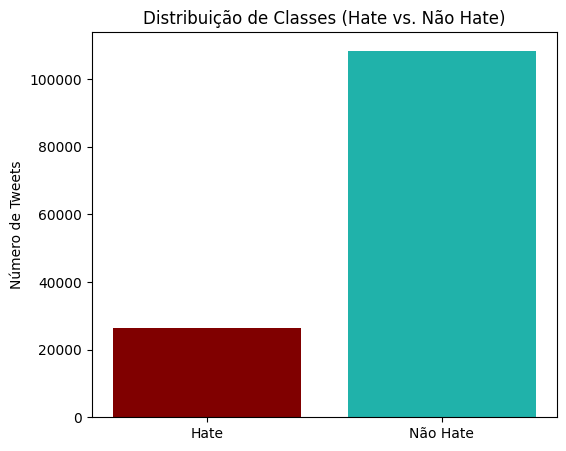

In [8]:
train_labels_binary = processed_datasets['train']['label']
binary_labels_map = {0: "Não Hate", 1: "Hate"}
binary_label_counts = Counter(train_labels_binary)

df_binary_dist = pd.DataFrame({
    'Classe': [binary_labels_map[label] for label in binary_label_counts.keys()],
    'Quantidade': list(binary_label_counts.values())
})

print("Distribuição das Classes Após Binarização:")
print(df_binary_dist)
print(f"\nProporção 'Não Hate': {binary_label_counts[0] / len(train_labels_binary):.2%}")
print(f"Proporção 'Hate':     {binary_label_counts[1] / len(train_labels_binary):.2%}")

plt.figure(figsize=(6, 5))
plt.bar(df_binary_dist['Classe'], df_binary_dist['Quantidade'], color=['maroon', 'lightseagreen'])
plt.title('Distribuição de Classes (Hate vs. Não Hate)')
plt.ylabel('Número de Tweets')
plt.show()

## **Tratamento do Desbalanceamento das Classes**

Mesmo após a binarização das labels, as classes continuaram desbalanceadas. Por isso, foi aplicado um undersampling na classe majoritária, a fim de equilibrar a distribuição entre as classes.

Distribuição das Classes no Treino Após Undersampling:
label
1    26361
0    26361
Name: count, dtype: int64


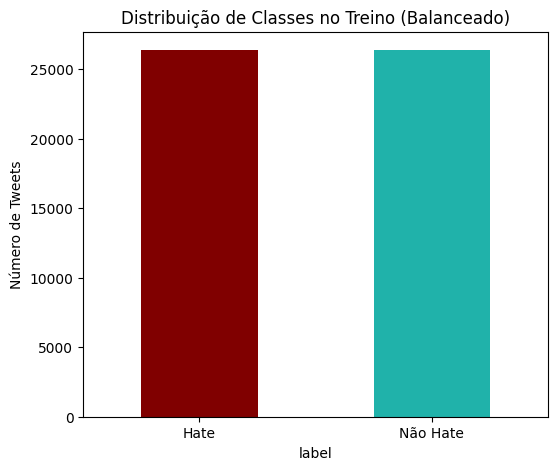

Map: 100%|██████████| 52722/52722 [00:22<00:00, 2321.03 examples/s]


In [9]:
df_train = processed_datasets['train'].to_pandas()

df_hate = df_train[df_train['label'] == 1]
df_not_hate = df_train[df_train['label'] == 0]

n_hate_samples = len(df_hate)
df_not_hate_undersampled = df_not_hate.sample(n=n_hate_samples, random_state=42)

df_train_balanced = pd.concat([df_hate, df_not_hate_undersampled]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Distribuição das Classes no Treino Após Undersampling:")
print(df_train_balanced['label'].value_counts())

balanced_train_dataset = Dataset.from_pandas(df_train_balanced)

plt.figure(figsize=(6, 5))
df_train_balanced['label'].value_counts().plot(kind='bar', color=['maroon', 'lightseagreen'])
plt.title('Distribuição de Classes no Treino (Balanceado)')
plt.xticks(ticks=[0, 1], labels=['Hate', 'Não Hate'], rotation=0)
plt.ylabel('Número de Tweets')
plt.show()

# Nomes dos arquivos
tweet_id_train = balanced_train_dataset['tweet_id']
tweet_id_val = val_dataset.to_pandas()['tweet_id'].tolist()
tweet_id_test = test_dataset.to_pandas()['tweet_id'].tolist()

# Remover colunas de tweet_id
balanced_train_dataset = balanced_train_dataset.remove_columns(['tweet_id'])
val_dataset = val_dataset.remove_columns(['tweet_id'])
test_dataset = test_dataset.remove_columns(['tweet_id'])

len(tweet_id_train), len(tweet_id_val), len(tweet_id_test)

tokenized_balanced_train_dataset = balanced_train_dataset.map(tokenize_function, batched=True, remove_columns=['text'])
tokenized_balanced_train_dataset = tokenized_balanced_train_dataset.rename_column("label", "labels")
tokenized_balanced_train_dataset.set_format("torch")

# **Treinamento do Modelo**

O treinamento do modelo foi realizado utilizando a classe Trainer da biblioteca Hugging Face. Como a tarefa consiste em classificação binária (Hate ou Não Hate), foi definida uma função de métricas personalizada para calcular accuracy, f1-score, precision e recall, sendo o f1-score utilizado como principal métrica de desempenho, devido ao seu balancamente de precisão e recall.

Foram utilizados os seguintes parâmetros de configuração:

* Épocas: 10
* Taxa de aprendizado: 2e-5
* Batch size (treinamento): 32
* Batch size (validação): 64

A avaliação e o salvamento do modelo ocorrem ao final de cada época. Foi incluído também o uso de EarlyStopping, com paciência de 2 épocas sem melhoria, para evitar overfitting.

In [8]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

def compute_binary_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average='binary')
    precision = precision_score(labels, preds, average='binary')
    recall = recall_score(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)

    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=8,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",
    warmup_steps=100,
    lr_scheduler_type="linear"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_balanced_train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_binary_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.613400,0.606531,0.681800,0.623610,0.664985,0.587082
2,0.591800,0.613571,0.687200,0.635601,0.666341,0.607572
3,0.545600,0.661110,0.670000,0.641616,0.626113,0.657906
4,0.462900,0.760684,0.649400,0.593931,0.618726,0.571047
5,0.377100,0.869675,0.637400,0.596304,0.596171,0.596437


TrainOutput(global_step=8240, training_loss=0.5220478187486963, metrics={'train_runtime': 16486.3653, 'train_samples_per_second': 25.583, 'train_steps_per_second': 0.8, 'total_flos': 1.73396763258624e+16, 'train_loss': 0.5220478187486963, 'epoch': 5.0})

# **Resultados**

Para avaliar o desempenho do modelo, foi utilizada a partição de teste, que não havia sido vista durante o treinamento. As métricas calculadas foram: acurácia, precisão, recall e f1-score. Em seguida, foi gerada a matriz de confusão, que ajuda a visualizar como o modelo está classificando corretamente ou incorretamente cada classe (Hate e Não Hate).

Por fim, foi plotado um gráfico da loss por época, tanto para o conjunto de treinamento quanto de validação, com o objetivo de verificar se o modelo apresenta sinais de overfitting.

{'eval_loss': 0.6815511584281921, 'eval_accuracy': 0.6539, 'eval_f1': 0.6282092598560532, 'eval_precision': 0.5989348627611635, 'eval_recall': 0.660492432798735, 'eval_runtime': 1099.9528, 'eval_samples_per_second': 9.091, 'eval_steps_per_second': 0.143, 'epoch': 5.0}


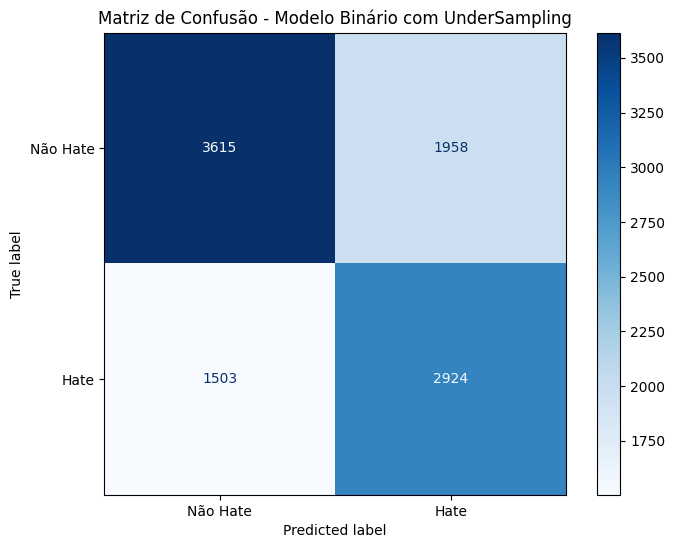

In [9]:
results = trainer.evaluate(test_dataset)
print(results)

predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids


cm = confusion_matrix(labels, preds, labels=list(binary_labels_map.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(binary_labels_map.values()))

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", values_format='d', ax=ax)
plt.title("Matriz de Confusão - Modelo Binário com UnderSampling")
plt.grid(False)
plt.show()

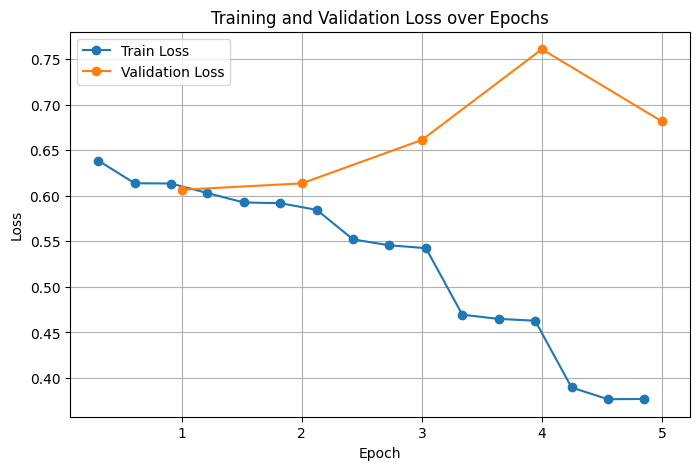

In [10]:
log_history = trainer.state.log_history

# Coletar dados do treino (mantido igual)
epochs, train_loss = [], []
for log in log_history:
    if 'loss' in log and 'epoch' in log:
        train_loss.append(log['loss'])
        epochs.append(log['epoch'])

# Corrigir os tamanhos do treino
train_epochs = epochs[:len(train_loss)]

# Coletar dados de validação e agrupar por época arredondada
eval_logs = [(round(log['epoch']), log['eval_loss']) for log in log_history if 'eval_loss' in log and 'epoch' in log]

# Remover duplicatas (último valor de cada época)
eval_dict = {}
for epoch, loss in eval_logs:
    eval_dict[epoch] = loss  # sobrescreve mantendo só o último da época

# Ordenar por época
eval_epochs = sorted(eval_dict.keys())
eval_loss = [eval_dict[ep] for ep in eval_epochs]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_epochs, train_loss, label="Train Loss", marker='o')
plt.plot(eval_epochs, eval_loss, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

## **Conclusão**

O modelo de rede neural treinado para a detecção de discurso de ódio apresentou desempenho razoável, com uma acurácia de 0,66 e um F1-score de 0,63, indicando um equilíbrio moderado entre precisão e revocação. No entanto, ao analisar a matriz de confusão, percebe-se uma certa tendência à confusão entre as classes: o modelo identificou corretamente 2.890 instâncias de discurso de ódio, mas também classificou erroneamente 1.797 textos não ofensivos como ofensivos.

Além disso, o gráfico de loss sugere uma possível tendência ao overfitting, com a perda de validação começando a subir enquanto a de treino continua caindo. No entanto, não é possível afirmar com certeza que o modelo sofreria overfitting severo, já que o treinamento foi interrompido antecipadamente por meio do EarlyStoppingCallback(patience=2). Também houve limitações de software e recursos computacionais, que impediram a execução de mais épocas, restringindo a análise completa do comportamento do modelo ao longo de um treinamento mais extenso.

# **Salvar embeddings do BERT**

O código implementa um processo eficiente de extração de representações vetoriais densas a partir de entradas textuais tokenizadas, utilizando os embeddings do token especial [CLS] de um modelo BERT para capturar o significado global de cada sequência. Essa extração é feita em lotes, sem atualização dos pesos, e com o modelo operando em modo de avaliação, o que economiza recursos computacionais. Devido a limitações de hardware e para evitar longas execuções, os embeddings são salvos em arquivos .npy, funcionando como checkpoints intermediários, permitindo que o processamento seja retomado de forma incremental ou reutilizado diretamente em etapas posteriores da fusão multimodal, sem a necessidade de reprocessar os dados novamente.


In [11]:
from tqdm import tqdm

def extract_cls_embeddings_from_tokenized(dataset, batch_size, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    model.eval()
    embeddings = []

    for i in tqdm(range(0, len(dataset), batch_size)):
        batch = dataset[i:i+batch_size]

        # Extrair tensores diretamente do batch
        input_ids = torch.tensor(batch['input_ids']).to(device)
        attention_mask = torch.tensor(batch['attention_mask']).to(device)
        token_type_ids = torch.tensor(batch['token_type_ids']).to(device)

        with torch.no_grad():
            outputs = model.bert(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )
            last_hidden_state = outputs.last_hidden_state
            cls_tokens = last_hidden_state[:, 0, :]  # [CLS]

        embeddings.append(cls_tokens.cpu().numpy())

    return np.vstack(embeddings)


# Extrair os embeddings do tokenized_balanced_train_dataset
text_embeddings_train = extract_cls_embeddings_from_tokenized(tokenized_balanced_train_dataset, batch_size=32)

# Salvar em arquivo
np.save("text_cls_embeddings_train.npy", text_embeddings_train)

# Extrair os embeddings do val_dataset
text_embeddings_val = extract_cls_embeddings_from_tokenized(val_dataset, batch_size=64)

# Salvar em arquivo
np.save("text_cls_embeddings_val.npy", text_embeddings_val)

# Extrair os embeddings do test_dataset
text_embeddings_test = extract_cls_embeddings_from_tokenized(test_dataset, batch_size=32)

# Salvar em arquivo
np.save("text_cls_embeddings_test.npy", text_embeddings_test)

# Shapes
text_embeddings_train.shape, text_embeddings_val.shape, text_embeddings_test.shape

  0%|          | 0/1648 [00:00<?, ?it/s]C:\Users\pamga\AppData\Local\Temp\ipykernel_8648\4255244396.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(batch['input_ids']).to(device)
C:\Users\pamga\AppData\Local\Temp\ipykernel_8648\4255244396.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(batch['attention_mask']).to(device)
C:\Users\pamga\AppData\Local\Temp\ipykernel_8648\4255244396.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_type_ids = torch.tensor(batch['token_

((52722, 768), (5000, 768), (10000, 768))

# **Salvar embeddings da imagem**

O código implementa um pipeline para extração de embeddings visuais a partir de imagens, usando um modelo Swin Transformer pré-treinado com a camada de classificação removida, de modo que o modelo retorne apenas representações vetoriais de alto nível. As imagens são organizadas por meio da classe FilteredImageDataset, que garante que apenas arquivos correspondentes aos identificadores válidos — previamente definidos para treino, validação e teste — sejam utilizados. As imagens passam por transformações padrão de pré-processamento e, em seguida, são convertidas em embeddings pelo modelo. Para contornar limitações de hardware e evitar que o processo precise ser refeito em caso de interrupções ou longas execuções, os embeddings são salvos em arquivos .pt, funcionando como checkpoints reutilizáveis que permitem acelerar e modular o pipeline de aprendizado multimodal sem reextrair os dados visuais a cada execução.











In [12]:
# Classe para separar as imagens em treino, validação e teste, conforme divisão feita para o BERT
class FilteredImageDataset(Dataset):
    def __init__(self, folder_path, valid_ids, transform=None):
        self.folder_path = folder_path
        self.transform = transform

        all_files = os.listdir(folder_path)

        self.image_files = [
            os.path.join(folder_path, f)
            for f in all_files
            if os.path.splitext(f)[0] in valid_ids and f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]

        print(f"{len(self.image_files)} imagens filtradas encontradas.")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        return img, os.path.basename(img_path)

In [13]:
len(tweet_id_train), len(tweet_id_val), len(tweet_id_test)

(52722, 5000, 10000)

In [14]:
# Caminho para as imagens
img_dir = path + '/img_resized'

# Carrega o Swin Transformer pré-treinado
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True) # output 768

# Remove a última camada de classificação (head)
model.reset_classifier(0)  # remove classification head → agora retorna só o embedding

model.eval()  # modo avaliação
model.to('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
def extract_and_save_embeddings(model, dataset, output_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
    print(f"Total no dataset: {len(dataset)}")

    model.eval()
    model.to(device)

    all_embeddings = []
    # all_filenames = []

    with torch.no_grad():
        for i in range(len(dataset)):
            img, filename = dataset[i]
            img = img.unsqueeze(0).to(device)  # [1, C, H, W]
            embedding = model(img)             # [1, 768]
            all_embeddings.append(embedding.cpu())
            # all_filenames.append(filename)

    all_embeddings = torch.cat(all_embeddings, dim=0)  # [N, 768]

    print(f"Extraídos embeddings para {all_embeddings.shape[0]} imagens")
    print(f"Shape final dos embeddings: {all_embeddings.shape}")

    torch.save({
        'embeddings': all_embeddings,
        # 'filenames': all_filenames
    }, output_path)

    print(f"Embeddings salvos em '{output_path}'")

# --- Uso da função para treino, val e test ---
dataset_treino = FilteredImageDataset(img_dir, tweet_id_train, transform=transform)
extract_and_save_embeddings(model, dataset_treino, 'swin_embeddings_treino.pt')

dataset_val = FilteredImageDataset(img_dir, tweet_id_val, transform=transform)
extract_and_save_embeddings(model, dataset_val, 'swin_embeddings_val.pt')

dataset_test = FilteredImageDataset(img_dir, tweet_id_test, transform=transform)
extract_and_save_embeddings(model, dataset_test, 'swin_embeddings_test.pt')

52722 imagens filtradas encontradas.
Total no dataset: 52722
Extraídos embeddings para 52722 imagens
Shape final dos embeddings: torch.Size([52722, 768])
Embeddings salvos em 'swin_embeddings_treino.pt'
5000 imagens filtradas encontradas.
Total no dataset: 5000
Extraídos embeddings para 5000 imagens
Shape final dos embeddings: torch.Size([5000, 768])
Embeddings salvos em 'swin_embeddings_val.pt'
10000 imagens filtradas encontradas.
Total no dataset: 10000
Extraídos embeddings para 10000 imagens
Shape final dos embeddings: torch.Size([10000, 768])
Embeddings salvos em 'swin_embeddings_test.pt'


# **Multimodal**

## **Inicialização**

Este trecho inicializa o pipeline de treinamento para um classificador multimodal, carregando embeddings de texto e imagem previamente salvos como checkpoints. Os dados são organizados em conjuntos de treino, validação e teste, e processados em lotes via DataLoader. As funções de treino e avaliação são definidas para conduzir o aprendizado supervisionado e monitorar o desempenho com métricas como F1-score e matriz de confusão.

In [10]:
# --- CONFIGURAÇÕES ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
embed_dim = 768
num_heads = 8
num_classes = 2

# --- CARREGAR EMBEDDINGS ---

text_train = torch.tensor(np.load('text_cls_embeddings_train.npy')).float()
text_val = torch.tensor(np.load('text_cls_embeddings_val.npy')).float()
text_test = torch.tensor(np.load('text_cls_embeddings_test.npy')).float()
'''
text_train = torch.tensor(text_embeddings_train).float()
text_val = torch.tensor(text_embeddings_val).float()
text_test = torch.tensor(text_embeddings_test).float()
'''

img_train = torch.load('swin_embeddings_treino.pt')['embeddings'].float()
img_val = torch.load('swin_embeddings_val.pt')['embeddings'].float()
img_test = torch.load('swin_embeddings_test.pt')['embeddings'].float()

# --- LABELS (substitua pelos reais) ---
y_train = torch.tensor(balanced_train_dataset['label'])
y_val = torch.tensor(val_dataset['labels'])
y_test = torch.tensor(test_dataset['labels'])

# --- DATASETS ---
train_ds = TensorDataset(text_train, img_train, y_train)
val_ds = TensorDataset(text_val, img_val, y_val)
test_ds = TensorDataset(text_test, img_test, y_test)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

C:\Users\pamga\AppData\Local\Temp\ipykernel_15136\3178935358.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val = torch.tensor(val_dataset['labels'])
C:\Users\pamga\AppData\Local\Temp\ipykernel_15136\3178935358.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_dataset['labels'])


In [11]:
# --- Para o train_loader ---
all_train_0 = []
all_train_1 = []
all_train_2 = []

for batch in train_loader:
    x0, x1, x2 = batch
    all_train_0.append(x0)
    all_train_1.append(x1)
    all_train_2.append(x2)

train_0 = torch.cat(all_train_0, dim=0)
train_1 = torch.cat(all_train_1, dim=0)
train_2 = torch.cat(all_train_2, dim=0)

print("train_0 shape:", train_0.shape)
print("train_1 shape:", train_1.shape)
print("train_2 shape:", train_2.shape)

# --- Para o val_loader ---
all_val_0 = []
all_val_1 = []
all_val_2 = []

for batch in val_loader:
    x0, x1, x2 = batch
    all_val_0.append(x0)
    all_val_1.append(x1)
    all_val_2.append(x2)

val_0 = torch.cat(all_val_0, dim=0)
val_1 = torch.cat(all_val_1, dim=0)
val_2 = torch.cat(all_val_2, dim=0)

print()
print("val_0 shape:", val_0.shape)
print("val_1 shape:", val_1.shape)
print("val_2 shape:", val_2.shape)

# --- Para o test_loader ---
all_test_0 = []
all_test_1 = []
all_test_2 = []

for batch in test_loader:
    x0, x1, x2 = batch
    all_test_0.append(x0)
    all_test_1.append(x1)
    all_test_2.append(x2)

test_0 = torch.cat(all_test_0, dim=0)
test_1 = torch.cat(all_test_1, dim=0)
test_2 = torch.cat(all_test_2, dim=0)

print()
print("test_0 shape:", test_0.shape)
print("test_1 shape:", test_1.shape)
print("test_2 shape:", test_2.shape)

train_0 shape: torch.Size([52722, 768])
train_1 shape: torch.Size([52722, 768])
train_2 shape: torch.Size([52722])

val_0 shape: torch.Size([5000, 768])
val_1 shape: torch.Size([5000, 768])
val_2 shape: torch.Size([5000])

test_0 shape: torch.Size([10000, 768])
test_1 shape: torch.Size([10000, 768])
test_2 shape: torch.Size([10000])


In [12]:
# --- TREINO E AVALIAÇÃO ---
def train(model, loader):
    model.train()
    total_loss = 0
    for text, img, labels in loader:
        text, img, labels = text.to(device), img.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(text, img)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, label_names=None, plot_confusion=True):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for text, img, labels in loader:
            text, img = text.to(device), img.to(device)
            output = model(text, img)
            preds = output.argmax(dim=1).cpu()
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.cpu().numpy())

    # Métricas de classificação
    print("=== Classification Report ===")
    print(classification_report(all_labels, all_preds, target_names=label_names))

    # Matriz de confusão
    cm = confusion_matrix(all_labels, all_preds)

    if plot_confusion:
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=label_names, yticklabels=label_names)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.show()

    # F1-score macro
    f1 = f1_score(all_labels, all_preds, average='macro')
    return f1

## **Concatenação simples**

Esse modelo realiza uma concatenação simples dos embeddings de duas modalidades (texto e imagem), combinando-os em um único vetor que é passado por uma rede neural totalmente conectada (MLP) para realizar a classificação. Ele não modela interações explícitas entre os dois tipos de entrada, mas se beneficia da simplicidade, menor risco de overfitting e rapidez de treinamento.

In [18]:
# --- MODELO COM CONCATENAÇÃO SIMPLES ---
class ConcatMultimodalClassifier(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=256, num_classes=2):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim * 2, hidden_dim),  # 768 texto + 768 imagem = 1536
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, text_emb, img_emb):
        fused = torch.cat([text_emb, img_emb], dim=1)  # (B, 1536)
        return self.classifier(fused)

=== Classification Report ===
              precision    recall  f1-score   support

    não hate       0.69      0.68      0.69      2755
        hate       0.61      0.62      0.62      2245

    accuracy                           0.65      5000
   macro avg       0.65      0.65      0.65      5000
weighted avg       0.65      0.65      0.65      5000

Epoch 1: Loss=0.4417 | Val F1=0.6506
Melhor modelo salvo.
=== Classification Report ===
              precision    recall  f1-score   support

    não hate       0.69      0.67      0.68      2755
        hate       0.61      0.62      0.61      2245

    accuracy                           0.65      5000
   macro avg       0.65      0.65      0.65      5000
weighted avg       0.65      0.65      0.65      5000

Epoch 2: Loss=0.4197 | Val F1=0.6461
Sem melhora. Paciente: 1/2
=== Classification Report ===
              precision    recall  f1-score   support

    não hate       0.69      0.67      0.68      2755
        hate       0.60  

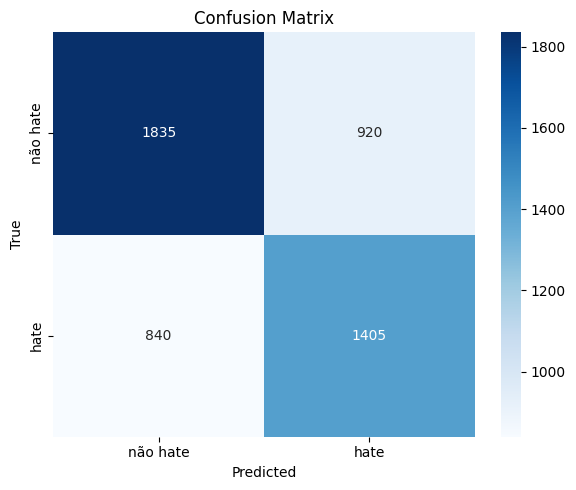

In [19]:
# --- TREINAMENTO COM CONCATENAÇÃO SIMPLES ---
model_simples = ConcatMultimodalClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_simples.parameters(), lr=1e-4)
best_f1 = 0.0
patience = 2        # Número de épocas sem melhora antes de parar
patience_counter = 0
best_model_state = None

for epoch in range(10):
    loss = train(model_simples, train_loader)

    # Avaliação na validação
    f1 = evaluate(model_simples, val_loader, label_names=['não hate', 'hate'], plot_confusion=False)

    print(f"Epoch {epoch+1}: Loss={loss:.4f} | Val F1={f1:.4f}")

    # Verifica se houve melhora
    if f1 > best_f1:
        best_f1 = f1
        patience_counter = 0
        best_model_state = model_simples.state_dict()  # Salva os pesos
        print("Melhor modelo salvo.")
    else:
        patience_counter += 1
        print(f"Sem melhora. Paciente: {patience_counter}/{patience}")

    # Parar se passar do limite de paciência
    if patience_counter >= patience:
        print("Early stopping ativado.")
        break

# Carrega o melhor modelo encontrado
if best_model_state is not None:
    model_simples.load_state_dict(best_model_state)
    print("Melhor modelo restaurado.")
    # Avaliação final com matriz de confusão
    print("\nAvaliação final no conjunto de validação com melhor modelo:")
    evaluate(model_simples, val_loader, label_names=['não hate', 'hate'], plot_confusion=True)

## **Concatenação Simples com Focal Loss**

Aqui é defino um classificador multimodal que combina embeddings de texto e imagem por concatenação, seguido por camadas lineares com ReLU e dropout para prever se um conteúdo é "hate" ou "não hate". Utiliza a Focal Loss, uma função de perda que foca em exemplos difíceis, ajustando o peso das amostras por meio dos parâmetros alpha e gamma. O treinamento e a validação são feitos com early stopping e avaliação em múltiplos thresholds de decisão, buscando a melhor combinação de alpha, gamma e threshold que maximize o F1-score macro. Ao final, o melhor modelo é reavaliado com matriz de confusão e relatório de classificação.


Treinando com FocalLoss alpha=0.25, gamma=1.5
Epoch 1: Loss=0.0402 | Val F1(0.5 threshold)=0.6473
Melhor modelo desta configuração salvo.
Epoch 2: Loss=0.0380 | Val F1(0.5 threshold)=0.6438
Sem melhora. Paciência: 1/2
Epoch 3: Loss=0.0369 | Val F1(0.5 threshold)=0.6455
Sem melhora. Paciência: 2/2
Early stopping ativado.
Melhor threshold para alpha=0.25, gamma=1.5 é 0.55 com F1=0.6504

Treinando com FocalLoss alpha=0.25, gamma=2.0
Epoch 1: Loss=0.0288 | Val F1(0.5 threshold)=0.6450
Melhor modelo desta configuração salvo.
Epoch 2: Loss=0.0272 | Val F1(0.5 threshold)=0.6413
Sem melhora. Paciência: 1/2
Epoch 3: Loss=0.0263 | Val F1(0.5 threshold)=0.6471
Melhor modelo desta configuração salvo.
Epoch 4: Loss=0.0254 | Val F1(0.5 threshold)=0.6486
Melhor modelo desta configuração salvo.
Epoch 5: Loss=0.0244 | Val F1(0.5 threshold)=0.6316
Sem melhora. Paciência: 1/2
Epoch 6: Loss=0.0233 | Val F1(0.5 threshold)=0.6348
Sem melhora. Paciência: 2/2
Early stopping ativado.
Melhor threshold para alp

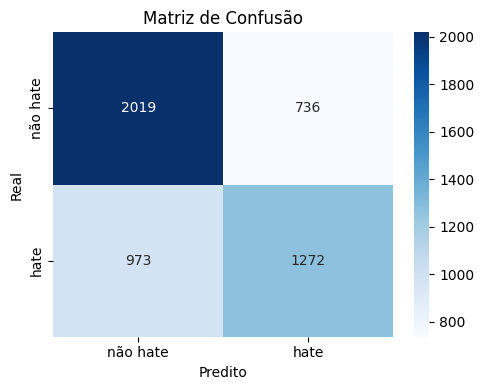

In [20]:
# Modelo multimodal
class ConcatMultimodalClassifier(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=256, num_classes=2):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )
    def forward(self, text_emb, img_emb):
        fused = torch.cat([text_emb, img_emb], dim=1)
        return self.classifier(fused)

# Focal Loss parametrizada
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')
    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Função treino
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for batch in dataloader:
        text_emb, img_emb, labels = [x.to(device) for x in batch]
        optimizer.zero_grad()
        outputs = model(text_emb, img_emb)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# Função avaliação com threshold customizado
def evaluate_with_threshold(model, dataloader, threshold=0.5, device='cuda'):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            text_emb, img_emb, labels = [x.to(device) for x in batch]
            outputs = model(text_emb, img_emb)  # logits
            probs = torch.softmax(outputs, dim=1)[:, 1]  # probabilidade classe "hate"
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    preds = (all_probs >= threshold).astype(int)

    f1 = f1_score(all_labels, preds, average='macro')
    return f1, all_labels, preds

def classification_report_and_cm(labels, preds, label_names=['não hate', 'hate'], plot_confusion=True):
    print("\n=== Classification Report ===")
    print(classification_report(labels, preds, target_names=label_names, digits=4))
    if plot_confusion:
        cm = confusion_matrix(labels, preds)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=label_names, yticklabels=label_names)
        plt.xlabel("Predito")
        plt.ylabel("Real")
        plt.title("Matriz de Confusão")
        plt.tight_layout()
        plt.show()

# Loop principal para testar alpha/gamma e thresholds
def run_training_with_focal_and_thresholds(train_loader, val_loader, num_epochs=10, patience=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    best_overall_f1 = 0.0
    best_model_state = None
    best_alpha_gamma = (None, None)
    best_threshold = 0.5

    alphas = [0.25, 0.5, 0.75]
    gammas = [1.5, 2.0, 3.0]

    for alpha in alphas:
        for gamma in gammas:
            print(f"\nTreinando com FocalLoss alpha={alpha}, gamma={gamma}")
            model = ConcatMultimodalClassifier().to(device)
            criterion = FocalLoss(alpha=alpha, gamma=gamma)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

            best_f1 = 0.0
            patience_counter = 0
            best_epoch_state = None

            for epoch in range(num_epochs):
                loss = train(model, train_loader, criterion, optimizer, device)
                # Avaliação com threshold fixo 0.5 só para monitorar
                f1, _, _ = evaluate_with_threshold(model, val_loader, threshold=0.5, device=device)
                print(f"Epoch {epoch+1}: Loss={loss:.4f} | Val F1(0.5 threshold)={f1:.4f}")

                if f1 > best_f1:
                    best_f1 = f1
                    patience_counter = 0
                    best_epoch_state = model.state_dict()
                    print("Melhor modelo desta configuração salvo.")
                else:
                    patience_counter += 1
                    print(f"Sem melhora. Paciência: {patience_counter}/{patience}")

                if patience_counter >= patience:
                    print("Early stopping ativado.")
                    break

            # Carrega melhor estado do modelo
            model.load_state_dict(best_epoch_state)

            # Testa thresholds variados
            thresholds = np.arange(0.1, 0.91, 0.05)
            best_thresh_f1 = 0.0
            best_thresh = 0.5

            for t in thresholds:
                f1_t, labels, preds = evaluate_with_threshold(model, val_loader, threshold=t, device=device)
                if f1_t > best_thresh_f1:
                    best_thresh_f1 = f1_t
                    best_thresh = t

            print(f"Melhor threshold para alpha={alpha}, gamma={gamma} é {best_thresh:.2f} com F1={best_thresh_f1:.4f}")

            if best_thresh_f1 > best_overall_f1:
                best_overall_f1 = best_thresh_f1
                best_threshold = best_thresh
                best_alpha_gamma = (alpha, gamma)
                best_model_state = model.state_dict()

    print(f"\nMelhor resultado geral com alpha={best_alpha_gamma[0]}, gamma={best_alpha_gamma[1]}, threshold={best_threshold:.2f}")
    print(f"F1 macro: {best_overall_f1:.4f}")

    # Restaura o melhor modelo
    best_model = ConcatMultimodalClassifier().to(device)
    best_model.load_state_dict(best_model_state)

    # Avaliação final e plot
    f1_final, labels, preds = evaluate_with_threshold(best_model, val_loader, threshold=best_threshold, device=device)
    classification_report_and_cm(labels, preds, plot_confusion=True)

    return best_model, best_alpha_gamma, best_threshold

best_model, best_alpha_gamma, best_threshold = run_training_with_focal_and_thresholds(train_loader, val_loader)

## **Multihead Attention**

Esse modelo, que obteve o melhor desempenho, projeta os embeddings das duas modalidades para o mesmo espaço vetorial e aplica uma atenção multi-cabeças (MultiheadAttention) para permitir que cada entrada (texto e extra) "atenda" à outra, capturando relações dinâmicas entre elas. Após a atenção, ele realiza pooling e passa por camadas feedforward antes da classificação. A atenção permite que o modelo aprenda pesos diferentes para cada modalidade, mas a arquitetura mais complexa pode exigir mais dados para ser eficaz. 

In [24]:
# --- TREINO E AVALIAÇÃO ---
def train(model, loader):
    model.train()
    total_loss = 0
    for text, img, labels in loader:
        text, img, labels = text.to(device), img.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(text, img)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, label_names=None, plot_confusion=True):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for text, img, labels in loader:
            text, img = text.to(device), img.to(device)
            output = model(text, img)
            preds = output.argmax(dim=1).cpu()
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.cpu().numpy())

    # Métricas de classificação
    print("=== Classification Report ===")
    print(classification_report(all_labels, all_preds, target_names=label_names))

    # Matriz de confusão
    cm = confusion_matrix(all_labels, all_preds)

    if plot_confusion:
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=label_names, yticklabels=label_names)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.show()

    # F1-score macro
    f1 = f1_score(all_labels, all_preds, average='macro')
    return f1

In [25]:
class MultimodalAttentionClassifier(nn.Module):
    def __init__(self, dim_input=768, hidden_dim=1024, num_heads=8, num_classes=2):
        super().__init__()

        self.text_proj = nn.Linear(dim_input, hidden_dim)
        self.extra_proj = nn.Linear(dim_input, hidden_dim)

        self.layernorm_pre = nn.LayerNorm(hidden_dim)
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True, dropout=0.2)

        self.ffn = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, text_embed, extra_feat):
        text = self.text_proj(text_embed).unsqueeze(1)     # (B, 1, D)
        extra = self.extra_proj(extra_feat).unsqueeze(1)   # (B, 1, D)

        combined = torch.cat([text, extra], dim=1)         # (B, 2, D)
        combined = self.layernorm_pre(combined)            # Pre-LN

        attn_output, _ = self.attention(combined, combined, combined)  # (B, 2, D)
        pooled = attn_output.mean(dim=1)                   # (B, D)

        x = self.ffn(pooled)
        return self.classifier(x)

In [32]:
# --- TREINAMENTO COM MULTIHEAD ATTENTION ---
model_attention = MultimodalAttentionClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_attention.parameters(), lr=2e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.7)
best_model_state = None
best_f1 = 0.0
patience = 2
counter = 0

for epoch in range(30):
    loss = train(model_attention, train_loader)
    val_f1 = evaluate(model_attention, val_loader, label_names=["não hate", "hate"], plot_confusion=False)
    scheduler.step(val_f1)
    print(f"Epoch {epoch+1}: Loss={loss:.4f} | Val F1={val_f1:.4f}")

    scheduler.step(val_f1)

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model_state = model.state_dict()
        counter = 0
        print("Melhoria! Modelo salvo.")
    else:
        counter += 1
        print(f"Sem melhora. Paciência: {counter}/{patience}")
        if counter >= patience:
            print("Early stopping ativado.")
            break

=== Classification Report ===
              precision    recall  f1-score   support

    não hate       0.69      0.62      0.65      2755
        hate       0.59      0.66      0.62      2245

    accuracy                           0.64      5000
   macro avg       0.64      0.64      0.64      5000
weighted avg       0.64      0.64      0.64      5000

Epoch 1: Loss=0.4398 | Val F1=0.6374
Melhoria! Modelo salvo.
=== Classification Report ===
              precision    recall  f1-score   support

    não hate       0.68      0.70      0.69      2755
        hate       0.62      0.60      0.61      2245

    accuracy                           0.66      5000
   macro avg       0.65      0.65      0.65      5000
weighted avg       0.66      0.66      0.66      5000

Epoch 2: Loss=0.4247 | Val F1=0.6511
Melhoria! Modelo salvo.
=== Classification Report ===
              precision    recall  f1-score   support

    não hate       0.68      0.65      0.67      2755
        hate       0.59  

## **Baseado em Transformers**

Esse modelo usa uma abordagem ainda mais avançada, tratando os embeddings das duas modalidades como uma sequência de dois tokens e processando-os com um Transformer Encoder completo, com múltiplas camadas de autoatenção e positional embeddings. Ele é projetado para capturar relações contextuais profundas entre as modalidades, semelhante aos Transformers usados em NLP. Após o encoding, aplica-se um pooling médio seguido de um classificador MLP. Embora poderoso, sua complexidade pode levar ao overfitting em datasets pequenos ou desbalanceados, como é o caso.

In [29]:
class MultimodalTransformerClassifier(nn.Module):
    def __init__(self, dim_input=768, hidden_dim=768, num_heads=6, num_layers=3, num_classes=2, dropout=0.2):
        super().__init__()

        # Projeção dos inputs para hidden_dim
        self.text_proj = nn.Linear(dim_input, hidden_dim)
        self.extra_proj = nn.Linear(dim_input, hidden_dim)

        # Positional Encoding simples (pois sequência curta, 2 tokens)
        self.pos_embedding = nn.Parameter(torch.zeros(1, 2, hidden_dim))

        # Encoder Transformer com múltiplas camadas
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classificador final
        self.classifier = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim//2, num_classes)
        )

    def forward(self, text_embed, extra_feat):
        # Projeção para mesmo espaço
        text = self.text_proj(text_embed).unsqueeze(1)   # (B, 1, D)
        extra = self.extra_proj(extra_feat).unsqueeze(1) # (B, 1, D)

        x = torch.cat([text, extra], dim=1)              # (B, 2, D)

        # Adiciona embedding posicional
        x = x + self.pos_embedding

        # Passa pelo encoder transformer multi-camadas
        x = self.transformer_encoder(x)                   # (B, 2, D)

        # Pooling simples (média)
        pooled = x.mean(dim=1)                            # (B, D)

        # Classificação
        out = self.classifier(pooled)

        return out

In [31]:
model = MultimodalTransformerClassifier(
).to(device)


# Define função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.7)
best_model_state = None
best_f1 = 0.0
patience = 2
counter = 0

for epoch in range(30):
    loss = train(model, train_loader)
    val_f1 = evaluate(model, val_loader, label_names=["não hate", "hate"], plot_confusion=False)
    scheduler.step(val_f1)
    print(f"Epoch {epoch+1}: Loss={loss:.4f} | Val F1={val_f1:.4f}")

    scheduler.step(val_f1)

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model_state = model.state_dict()
        counter = 0
        print("Melhoria! Modelo salvo.")
    else:
        counter += 1
        print(f"Sem melhora. Paciência: {counter}/{patience}")
        if counter >= patience:
            print("Early stopping ativado.")
            break

=== Classification Report ===
              precision    recall  f1-score   support

    não hate       0.69      0.60      0.64      2755
        hate       0.58      0.67      0.62      2245

    accuracy                           0.63      5000
   macro avg       0.63      0.63      0.63      5000
weighted avg       0.64      0.63      0.63      5000

Epoch 1: Loss=0.4389 | Val F1=0.6295
Melhoria! Modelo salvo.
=== Classification Report ===
              precision    recall  f1-score   support

    não hate       0.68      0.59      0.63      2755
        hate       0.57      0.67      0.61      2245

    accuracy                           0.62      5000
   macro avg       0.63      0.63      0.62      5000
weighted avg       0.63      0.62      0.62      5000

Epoch 2: Loss=0.4231 | Val F1=0.6232
Sem melhora. Paciência: 1/2
=== Classification Report ===
              precision    recall  f1-score   support

    não hate       0.68      0.69      0.69      2755
        hate       0.

# **Desempenho na Base de Teste**

Multihead Attention obteve desempenho equilibrado entre as classes "hate" e "não hate", com acurácia geral de 63%. A classe "não hate" teve maior precisão (0.69), indicando menos falsos positivos, enquanto a classe "hate" apresentou maior recall (0.65), mostrando boa capacidade de identificar discursos de ódio, embora com mais falsos positivos. O F1-score macro de 0.63 indica desempenho médio consistente entre as classes, o que é desejável em tarefas com importância equivalente para ambas. Esses resultados refletem que a atenção multi-cabeça consegue capturar relações relevantes nos dados, mas ainda há espaço para melhorias, especialmente na distinção entre as classes em cenários ambíguos.

=== Classification Report ===
              precision    recall  f1-score   support

    não hate       0.69      0.62      0.65      5573
        hate       0.58      0.65      0.61      4427

    accuracy                           0.63     10000
   macro avg       0.63      0.63      0.63     10000
weighted avg       0.64      0.63      0.63     10000



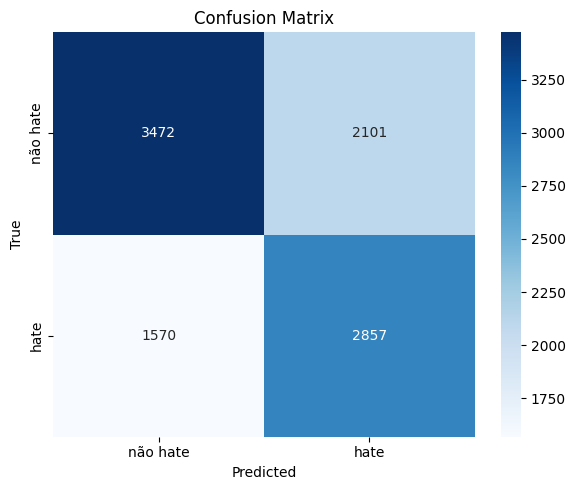

In [39]:
f1_test = evaluate(model_attention, test_loader, label_names=['não hate', 'hate'], plot_confusion=True)